<div class="alert alert-block alert-info"> 
- __[Shortcuts](https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/)__
- __[Markdown](http://datascience.ibm.com/blog/markdown-for-jupyter-notebooks-cheatsheet/)__

##  Importação bibliotecas

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import utente

import importlib as imp
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Carregamento dos dados

In [137]:
imp.reload(sys.modules['utente'])
listaUtentes = utente.ListaUtentes() # passar parâmetro forceFetch = True para forçar leitura BD 

Loading from ./temp/ListaUtentes.pickle
Finished


In [3]:
# Output do Histórico de todos Utentes para txt DEMORADO!
#listaUtentes.output2FileHistoricosTodosUtentes()

In [138]:
# Criação do dataframe pandas
df = pd.DataFrame(listaUtentes.generateDataset())

In [264]:
df.columns

Index(['ConjugeMotivoIndisponibilidade', 'Data', 'DataNascimento',
       'DiasDesemprego', 'Empregado?', 'EstadoCivil', 'LTU?', 'Nacionalidade',
       'NivelDeficiencia', 'NrAnulacoes',
       'NrAnulacoesPorMotivo_CADUCIDADE DO DOCUMENTO DE IDENTIFICAÇÃO',
       'NrAnulacoesPorMotivo_COLOCAÇÃO - CANDIDATURA EXTERNA',
       'NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA DE OUTREM',
       'NrAnulacoesPorMotivo_COLOCAÇÃO POR MEIOS PRÓPRIOS, POR CONTA PRÓPRIA',
       'NrAnulacoesPorMotivo_CORRECÇÃO COLOCAÇÃO FME',
       'NrAnulacoesPorMotivo_CORRECÇÃO REINSCRIÇÃO FME',
       'NrAnulacoesPorMotivo_CRIAÇÃO DO PRÓPRIO EMPREGO',
       'NrAnulacoesPorMotivo_CUMPRIMENTO SERVIÇO MILITAR',
       'NrAnulacoesPorMotivo_DESISTIU',
       'NrAnulacoesPorMotivo_DESISTÊNCIA OU EXCLUSÃO DE FORMAÇÃO',
       'NrAnulacoesPorMotivo_DESISTÊNCIA OU EXCLUSÃO DE MEDIDAS DE EMPREGO (EXCLUI TRABALHO SOCIALMENTE NECESSÁRIO)',
       'NrAnulacoesPorMotivo_DESISTÊNCIA OU EXCLUSÃO DE TRABALH

## Limpeza das variáveis

Substituição de `None` por 0's e correcção do Types

In [139]:
# DataNascimento
df['DataNascimento'].fillna(value=np.nan, inplace = True)
df['DataNascimento'] = pd.to_datetime(df['DataNascimento'])

In [140]:
# Substitui por 0 todos Nones nas colunas que 
# começam por NrAnulacoesPorMotivo ou NrApresentacoesComResultado
filter_col = [col for col in df if col.startswith('NrAnulacoesPorMotivo') 
                                   or col.startswith('NrApresentacoesComResultado')]

for col in filter_col:
    df[col].fillna(value=0, inplace = True);
    df[col]=df[col].astype('int');

In [141]:
# Empregado?
df['Empregado?'] = df['Empregado?'].astype('category')

## Novas Features

### Idade

In [155]:
df['Idade'] = (df['Data']-df['DataNascimento']).astype('timedelta64[Y]')

***

## Análise Exploratória Univariada

### LTU

In [149]:
df['LTU?'] = df['LTU?'].astype('category');
df['LTU?'].describe()

count     123701
unique         3
top            ?
freq       75608
Name: LTU?, dtype: object

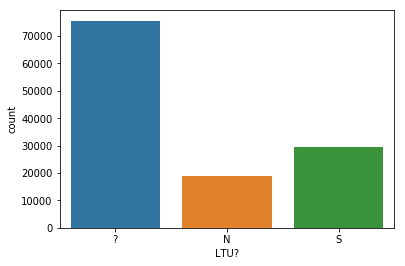

In [148]:
sns.countplot(x='LTU?', data=df);

### DiasDesemprego

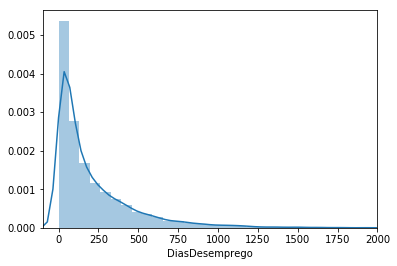

In [236]:
df_empregados = df[(df['Empregado?']=='S')] 
# Só faz sentido mostrar aqueles que acabaram por ficar empregados
sns.distplot(df_empregados['DiasDesemprego'])
plt.xlim(-100, 2000);

In [255]:
#skewness e kurtosis
print("Skewness: %f" % df['DiasDesemprego'].skew())
print("Kurtosis: %f" % df['DiasDesemprego'].kurt())

Skewness: 34.710146
Kurtosis: 5270.179240


### Idade

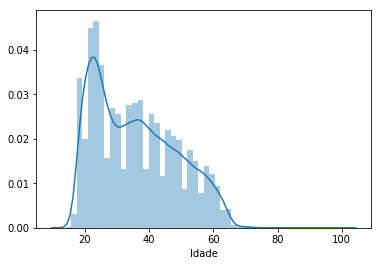

In [157]:
sns.distplot(df['Idade'].dropna())

***

## Análise Exploratória Multivariada

### DiasDesemprego-Sexo

Comparação das populações do sexo Masculino e Feminino em relação dos dias de desemprego.<br>
**Nota:** Deve-se filtar apenas as observações que resultaram em emprego pois só nesses casos sabemos ao certo quantos foram os dias que estiveram desempegados

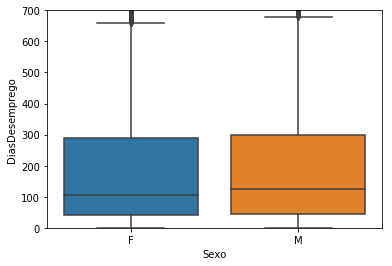

In [185]:
sns.boxplot(x='Sexo', y='DiasDesemprego', data=df2)
plt.ylim(0, 700);

Olhando para a Mediana, aparentemente os utentes do sexo masculino ficam mais tempo desempregados...

In [262]:
print("Sexo M: {:.0f} dias".format(df_empregados[df.Sexo == 'M']['DiasDesemprego'].median()))
print("Sexo F: {:.0f} dias".format(df_empregados[df.Sexo == 'F']['DiasDesemprego'].median()))

Sexo M: 125 dias
Sexo F: 106 dias


#### Sequências de eventos mais frequentes

In [44]:
listaEventos = [] # List de lists de eventos de cada utente [[Ut1_ev1, Ut1_ev2],[Ut2_ev1, Ut2_ev2]]
# Utiliza-se isto em vez de eventos em list única para os ngrams não incluirem eventos de dois utilizadores diferentes.

for ts, utente in listaUtentes.items():
    listaEventos.extend(utente.stringListOfEventsTypeDescription())

In [42]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

bcf = BigramCollocationFinder.from_documents(listaEventos)
#Metrics: http://www.nltk.org/_modules/nltk/metrics/association.html

In [43]:
bcf.score_ngrams(BigramAssocMeasures.student_t) # Retorna lista de ngrams ordenada desc. por score definido
#bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)

[(('Pedido de Emprego',
   'Intervenção | Outras Intervenções | INICIO PPE | INICIADO'),
  168.26858200107628),
 (('Mudança de Categoria | DESEMP NOVO EMPREGO - INDISPONÍVEL | DESEMPREGADO-NOVO EMPREGO',
   'Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | DESEMP NOVO EMPREGO - INDISPONÍVEL'),
  126.74446698569933),
 (('Anulacao | FALTA A CONVOCATÓRIA',
   'Intervenção | Outras Intervenções | FIM PPE | CONCLUIU'),
  124.69361187041027),
 (('Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | DESEMP NOVO EMPREGO - INDISPONÍVEL',
   'Mudança de Categoria | DESEMP NOVO EMPREGO - INDISPONÍVEL | DESEMPREGADO-NOVO EMPREGO'),
  110.96534376649883),
 (('Intervenção | Outras Intervenções | FIM PPE | CONCLUIU',
   'Pedido de Emprego'),
  107.95353988329443),
 (('Mudança de Categoria | OCUPADO | DESEMPREGADO-NOVO EMPREGO',
   'Mudança de Categoria | DESEMPREGADO-NOVO EMPREGO | OCUPADO'),
  107.90814623603477),
 (('Convocatória | OFERTA | APRESENTADO',
   'Apresentação | RECUSA DA ENTIDADE EMPREG

In [35]:
for k,v in bcf.nbest(BigramAssocMeasures.raw_freq, 5).ngram_fd.items():
    print(k,v)

AttributeError: 'list' object has no attribute 'ngram_fd'

### Fechar a ligação

In [82]:
connection.close()